Born data inversion test

In [1]:
import sys
sys.path.append("/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/lib/python/")
import genericIO
import SepVector
import Hypercube
import Acoustic_iso_double
import numpy as np
import time
#Solver library
import pyLCGsolver as LCG
import pyProblem as Prblm
import pyStopperBase as Stopper
from sys_util import logger

Creating background and reflectivity model

In [2]:
#Creating background model
!Pad <velocityMarmousi.H beg1=105 end1=105 beg2=102 end2=102 extend=1 | Pad beg1=5 end1=5 beg2=5 end2=5 > velocityMarmousi.pad.H
!Smooth <velocityMarmousi.pad.H rect1=5 rect2=5 repeat=3 > background.pad.H
#Creating reflectivity
!Add velocityMarmousi.pad.H background.pad.H scale=1,-1 > reflectivity.pad.H

Creating necessary variables for propagation

In [3]:
#Parameters for instantiating nonlinear operator
#First argument is just a dummy one since it mimics the name of the main program (i.e., we mimic sys.argv)
#vel = velocity model header file
#model = wavelet header file
#par = parameter file containing simulation information
args=["dummy arg","vel=background.pad.H","sources=wlt.H","model=reflectivity.pad.H","par=parPythonTest.p"]
modelDouble, dataDouble, velDouble, parObject, sourcesVector, sourcesSignalsVector, receiversVector = Acoustic_iso_double.BornOpInitDouble(args)
#Printing parameter file for reference
!cat parPythonTest.p


nts=1001
dts=0.004
sub=4
nz=570
nx=1914
zPadMinus=100
zPadPlus=110
xPadMinus=100
xPadPlus=104
dz=0.01
dx=0.01
fMax=16
zSource=10
xSource=850
nShot=50
spacingShots=1
depthReceiver=10
nReceiver=1700
dReceiver=1
oReceiver=1
saveWavefield=0
wavefieldShotNumber=0
blockSize=16
fat=5
nGpu=8


Create Born operator object

In [4]:
born_op=Acoustic_iso_double.BornShotsGpu(modelDouble,dataDouble,velDouble,parObject,sourcesVector,sourcesSignalsVector,receiversVector)


Generating Born data

In [5]:
t0 = time.time()
born_op.forward(False,modelDouble,dataDouble)
t1 = time.time()
print("Elapsed time = ",t1-t0," seconds")

Elapsed time =  13.576905488967896  seconds


Plotting the data

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


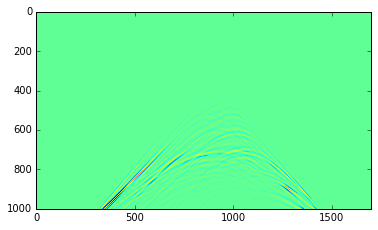

In [6]:
%matplotlib inline  
import matplotlib.pyplot as plt
data = np.reshape(dataDouble.getNdArray()[0,:,:],(1700,1001))
plt.imshow(data.T);

Inversion of Born Data

In [7]:
#Create L2-norm linear problem
model_vec = modelDouble.clone()
model_vec.zero()
L2Prob = Prblm.ProblemL2Linear(model_vec,dataDouble,born_op)
#Create stopper
niter = 10
Stop  = Stopper.BasicStopper(niter=niter)
#Create solver
LCGsolver = LCG.LCGsolver(Stop,logger=logger("test.log"))
LCGsolver.setDefaults(iter_buffer=None,iter_sampling=1)
#Running the solver
LCGsolver.run(L2Prob)

LINEAR CONJUGATE GRADIENT SOLVER
Restart folder: /tmp/restart_2019-01-09T16-21-47.585474/

iter = 0 obj = 2.5191091130445377e-07 residual norm = 0.0007098040659911931 gradient norm= 6.234287752704404e-08 feval = 2
iter = 1 obj = 1.9366218358761392e-07 residual norm = 0.0006223539239726961 gradient norm= 6.234287752704404e-08 feval = 3
iter = 2 obj = 1.8187795171609768e-07 residual norm = 0.0006031218217685819 gradient norm= 4.94103993275985e-08 feval = 5
iter = 3 obj = 1.672974578994257e-07 residual norm = 0.0005784417735412717 gradient norm= 3.815434368448223e-08 feval = 7
iter = 4 obj = 1.5464071452095582e-07 residual norm = 0.0005561307771131396 gradient norm= 2.244869889977963e-08 feval = 9
iter = 5 obj = 1.3317410477178675e-07 residual norm = 0.0005160893779247999 gradient norm= 4.7368729383379105e-08 feval = 11
iter = 6 obj = 1.2087990545071132e-07 residual norm = 0.0004916907637380064 gradient norm= 2.9243928167943523e-08 feval = 13
iter = 7 obj = 1.1237246262192267e-07 residual

In [ ]:
%matplotlib inline  
import matplotlib.pyplot as plt
model_np = np.array(L2Prob.model.getCpp(),copy=False)
plt.imshow(model_np)